In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


import argparse
import sys
sys.path.append('../../gears_misc/')

from gears import PertData, GEARS

dataset = 'norman_go'
data_path = '/dfs/project/perturb-gnn/datasets/data/'
model = 'gears'
device = 8
seed = 1


def load_data(seed):
    pert_data = PertData(data_path[:-1], gene_path='/dfs/user/yhr/gears2/Evaluation/data/essential_norman.pkl') # specific saved folder
    pert_data.load(data_path= data_path+dataset) # load the processed data, the path is saved folder + dataset_name
    pert_data.prepare_split(split = 'simulation', seed = seed)
    pert_data.get_dataloader(batch_size = 32, test_batch_size = 32)
    
    adata_df = pert_data.adata.to_df()
    adata_df['condition'] = pert_data.adata.obs['condition']
    mean_df = adata_df.groupby('condition').mean()
    ctrl_mean = mean_df.loc['ctrl']
    
    return pert_data, ctrl_mean, mean_df

def load_model(pert_data):
    gears_model = GEARS(pert_data, device = 'cuda:8', 
                weight_bias_track = False, 
                proj_name = 'norman_go', 
                exp_name = 'gears',
                gi_predict = True)
    gears_model.model_initialize(hidden_size = 64,
                             go_path='/dfs/user/yhr/gears2/Evaluation/data/go_essential_norman.csv')
    
    return gears_model
    

In [3]:
pert_data, ctrl_mean, mean_df = load_data(seed)
gears_model = load_model(pert_data)

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:3
combo_seen1:36
combo_seen2:14
unseen_single:23
Done!
Creating dataloaders....
Done!


In [6]:
gears_model.train(epochs = 0, lr = 1e-3)

Start Training...
Done!
Start Testing...
Best performing model: Test Top 20 DE MSE: 0.3800
Start doing subgroup analysis for simulation split...
test_combo_seen0_mse: 0.006323622
test_combo_seen0_pearson: 0.9806559784041194
test_combo_seen0_mse_de: 0.2618344
test_combo_seen0_pearson_de: 0.6190830506216072
test_combo_seen1_mse: 0.008314142
test_combo_seen1_pearson: 0.9749880303910091
test_combo_seen1_mse_de: 0.42130262
test_combo_seen1_pearson_de: 0.7880116617003616
test_combo_seen2_mse: 0.0064131385
test_combo_seen2_pearson: 0.9804280319921107
test_combo_seen2_mse_de: 0.5355386
test_combo_seen2_pearson_de: 0.8863124168685886
test_unseen_single_mse: 0.0035222282
test_unseen_single_pearson: 0.9892609538304451
test_unseen_single_mse_de: 0.23614056
test_unseen_single_pearson_de: 0.8547882827274502
test_combo_seen0_pearson_delta: 0.018298733264759146
test_combo_seen0_frac_opposite_direction_top20_non_dropout: 0.45
test_combo_seen0_frac_sigma_below_1_non_dropout: 0.7333333333333334
test_comb

In [9]:
### turn the model on 
model = gears_model.model
model.cell_fitness_pred = True


In [10]:
adata = gears_model.adata
ctrl_adata = adata[adata.obs['condition'] == 'ctrl']

In [12]:
all_pert_list_options = gears_model.pert_list

In [13]:
with open('/dfs/project/perturb-gnn/datasets/Norman2019/GI_data.pkl', 'rb') as f:
    fitness_data = pickle.load(f)
    
unique_pert_genes = fitness_data['good_phen'].index.values

from itertools import combinations
pert_list = [i[0] + '+' + i[1] for i in list(combinations(fitness_data['good_phen'].index.values, 2))]

In [16]:
class GI_expt():
    # TODO get rid of hold out genes
    def __init__(self, raw=False, pick_genes = None):
        # sample: matrix sampling percentage
        # seed: sampling seed,
        # sampled_data: sampled indices from upper traingle matrix
        # test: matrix values to be predicted
        # train: observed matrix values used for training, 
        # delta: deviation from expectation as inferred using 
        #        a regression model trained on sampled_data (corresponds to sampled_data)
        # delta_tot: delta values computed for all matrix values
        # y_tot: Full true matrix (raw fitness values)
        # raws: Sampled raw fitness values (corresponds to sampled_data)
        # transformer: regression model used to determine expected fitness values
        

        with open('GI_data.pkl', 'rb') as f:
            self.data = pickle.load(f)
        self.raw = raw
        self.pick_genes = pick_genes

    def pre_process(self, sample, seed):
        itr_data = {}
        itr_data['sample'] = sample
        itr_data['seed'] = seed

        # Randomly sample from the fitness matrix
        if self.pick_genes is None:
            itr_data['sampled_data'] = \
               upper_triangle(self.data['good_phen'], k=0).sample(
               frac=float(sample) / 100., replace=False, random_state=seed).index
        else:
            itr_data['sampled_data'] = \
                upper_triangle(self.data['good_phen'].iloc[self.pick_genes,
                                                    self.pick_genes]).index

        # Set up masked delta matrix for performing matrix completion
        itr_data['delta'], itr_data['test'], \
        itr_data['train'], itr_data['delta_tot'], \
        itr_data['X_tot'], itr_data['y_tot'], itr_data['transformer'], \
        itr_data['raws'] = \
            get_masked_delta_matrix(self.data['good_phen'],
                                    itr_data['sampled_data'],
                                    self.data['fitness_mapper_gene'],
                                    self.data['good_genes'])

        return itr_data


def get_masked_delta_matrix(data, sampling, phen_mapper, good_genes):
    masked_data, mask = get_masked_data(data, sampling)

    upper_masked_data = upper_triangle(masked_data)
    predicted = upper_masked_data[upper_masked_data == 0].index
    given = upper_masked_data[upper_masked_data != 0].index

    delta_tot, X, X_tot, y, y_tot, transformer, raws = get_deltas(data, masked_data, phen_mapper, good_genes)
    delta, _ = get_masked_data(delta_tot, sampling)
    raws, _ = get_masked_data(raws, sampling)

    return delta, predicted, given, delta_tot, X_tot, y_tot, transformer, raws

def get_deltas(source_data, sampled_data, phen_mapper, good_genes):
    # this is the routine that fits a quadratic model to observed fitness measurements and returns
    # the deviations from the expectation given by that model (the "deltas")
    y = sampled_data.stack()
    y = y[y != 0]

    X = np.concatenate([y.index.get_level_values(0).map(lambda x: phen_mapper[x]).values[:, np.newaxis],
                        y.index.get_level_values(1).map(lambda x: phen_mapper[x]).values[:, np.newaxis]], axis=1)

    y_tot = source_data.loc[good_genes, good_genes].stack()
    X_tot = np.concatenate([y_tot.index.get_level_values(0).map(lambda x: phen_mapper[x]).values[:, np.newaxis],
                            y_tot.index.get_level_values(1).map(lambda x: phen_mapper[x]).values[:, np.newaxis]],
                           axis=1)

    transformer = PolynomialFeatures()
    model = make_pipeline(PolynomialFeatures(), LinearRegression())
    model.fit(X, y)

    delta = pd.Series(y_tot - model.predict(X_tot), index=y_tot.index)
    raws = pd.Series(y_tot, index=y_tot.index).unstack()
    delta = delta.unstack()

    return delta, X, X_tot, y, y_tot, model, raws

def upper_triangle(M, k=1):
    """ Copyright (C) 2019  Thomas Norman
    Return the upper triangular part of a matrix in stacked format (i.e. as a vector)
    """
    keep = np.triu(np.ones(M.shape), k=k).astype('bool').reshape(M.size)
    return M.stack(dropna=False).loc[keep]

def get_masked_data(df, ind, mean_normalize=False):
    masked_data = df.copy().values
    mask = pd.DataFrame(0, index=df.index, columns=df.columns)

    for gene1, gene2 in ind:
        mask.loc[gene1, gene2] = 1

        # assume DataFrame is symmetric
    mask = mask + mask.T
    mask = (mask != 0).values
    masked_data[~mask] = 0
    masked_data_df = pd.DataFrame(masked_data, index=df.index, columns=df.columns)

    # whether to center the observed entries such that the overall mean is 0
    if mean_normalize:
        masked_data_df = masked_data_df.stack()
        offset = masked_data_df[masked_data_df != 0]
        offset = offset.mean()
        masked_data_df[masked_data_df != 0] = masked_data_df[masked_data_df != 0] - offset
        print(offset)
        masked_data_df = masked_data_df.unstack()

    return masked_data_df, mask

In [ ]:
# Run prediction
from torch_geometric.data import DataLoader

import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from copy import deepcopy

def evaluate(model, loader):
    model.eval()
    y_all = []
    loss_all = []
    pert_all = []
    y_true_all = []
    for step, batch in enumerate(tqdm(loader)):
        batch = batch.to(device)
        out, y_pred = model(batch)
        loss = loss_fct(batch.y.reshape(-1), y_pred.reshape(-1))
        loss_all.append(loss.item())
        y_all.append(y_pred.detach().cpu().numpy())
        pert_all.append(batch.pert)
        y_true_all.append(batch.y)
    return y_all, loss_all, pert_all, y_true_all

def get_dataloader(set2cond, batch_size, test_batch_size = None):
    if test_batch_size is None:
        test_batch_size = batch_size

    cell_graphs = {}
    

    splits = ['train','val','test']
    for i in splits:
        cell_graphs[i] = []
        for p in set2cond[i]:
            if p in all_cell_graphs:
                cell_graphs[i].extend(all_cell_graphs[p])

    # Set up dataloaders
    train_loader = DataLoader(cell_graphs['train'],
                        batch_size=batch_size, shuffle=True, drop_last = True)
    val_loader = DataLoader(cell_graphs['val'],
                        batch_size=batch_size, shuffle=True)

    test_loader = DataLoader(cell_graphs['test'],
                    batch_size=batch_size, shuffle=False)
    return {'train_loader': train_loader,
                        'val_loader': val_loader,
                        'test_loader': test_loader}

for sample_frac in [40, 50, 60]:
    for label in ['delta_tot', 'raw_y']:
        seed = 1

        GI = GI_expt(pick_genes=None)
        itr_data = GI.pre_process(sample=sample_frac, seed=seed)

        itr_data['raw_y'] = fitness_data['good_phen']
        y = itr_data[label].values

        gene2idx = dict(zip(itr_data[label].index.values, range(len(itr_data[label].index.values))))

        pert_list = [i[0] + '+' + i[1] for i in list(combinations(itr_data[label].index.values, 2))]
        pert_list += [i + '+ctrl' for i in unique_pert_genes]

        y_list = []
        for i in pert_list:
            if i.split('+')[1]!= 'ctrl':
                y_list.append(y[gene2idx[i.split('+')[0]], gene2idx[i.split('+')[1]]])
            else:
                y_list.append(y[gene2idx[i.split('+')[0]], gene2idx[i.split('+')[0]]])

        pert_list2y_list = dict(zip(pert_list, y_list))

        train = [i[0] + '+' + i[1] for i in itr_data['train']]
        test = [i[0] + '+' + i[1] for i in itr_data['test']]

        from sklearn.model_selection import train_test_split
        train, val, _, _ = train_test_split(train, [-1] * len(train), test_size=0.1, random_state=42)

        ## add single back
        train = train + [i + '+ctrl' for i in unique_pert_genes]

        set2cond = {
            'train': train,
            'val': val,
            'test': test
        }

        from torch_geometric.data import Data
        import torch
        from tqdm import tqdm
        num_samples = 100
        all_cell_graphs = {}
        pert_na = []
        for pert in tqdm(pert_list):
            pert_name = pert
            pert = pert.split('+')
            pert = [i for i in pert if i!='ctrl']

            # Get the indices (and signs) of applied perturbation
            try:
                pert_idx = [np.where(p == np.array(all_pert_list_options))[0][0] for p in pert]
                Xs = ctrl_adata[np.random.randint(0, len(ctrl_adata), num_samples), :].X.toarray()
                # Create cell graphs
                all_cell_graphs[pert_name] = [Data(x=torch.Tensor(X).T, pert_idx = pert_idx, pert=pert, y=pert_list2y_list[pert_name]) for X in Xs]
            except:
                pert_na.append(pert_name)

        loaders = get_dataloader(set2cond, batch_size = 32)
        train_loader = loaders['train_loader']
        val_loader = loaders['val_loader']
        test_loader = loaders['test_loader']

        optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay = 5e-4)
        scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

        loss_fct = F.mse_loss
        earlystop_validation_metric = 'mse'
        binary_output = False

        earlystop_direction = 'descend'
        min_val = np.inf

        best_model = deepcopy(model).to(device)

        loss_history = {
            'loss': []
        }

        print('Start Training...')
        for epoch in range(1):
            model.train()

            for step, batch in enumerate(tqdm(train_loader)):
                optimizer.zero_grad()
                batch = batch.to(device)
                out, y_pred = model(batch)
                loss = loss_fct(batch.y.float().reshape(-1), y_pred.reshape(-1))
                loss.backward()
                optimizer.step()
                loss_history['loss'].append(loss.item())

                if (step % 200 == 0) and (step >= 200):
                    log = "Epoch {} Step {} Train Loss: {:.4f}" 
                    print(log.format(epoch + 1, step + 1, loss.item()))
            #_, val_loss
            val_y_all, val_loss_all, val_pert_all, val_y_true_all = evaluate(model, val_loader)
            if np.mean(val_loss_all) < min_val:
                best_model = deepcopy(model)
                min_val = np.mean(val_loss_all)
        test_y_all, test_loss_all, test_pert_all, test_y_true_all = evaluate(best_model, test_loader)
        print(np.mean(test_loss_all))


        pert_test_list = [i[0] + '+' +  i[1] if len(i) == 2 else i[0] +'+ctrl' for i in [j for i in test_pert_all for j in i]]
        test_y_list = np.concatenate([i for i in [j for i in test_y_all for j in i]])
        test_y_true_list = np.concatenate([i.detach().cpu().numpy() for i in test_y_true_all])
        df_pred = pd.DataFrame((pert_test_list, test_y_true_list, test_y_list)).T
        pert2y_true = dict(df_pred.groupby([0])[1].agg(np.mean))
        pert2y_pred = dict(df_pred.groupby([0])[2].agg(np.mean))

        pred = pd.DataFrame(pert2y_true, index = [0]).T.reset_index().rename(columns = {0: 'truth', 'index': 'test_pert'})
        pred['pred'] = pred.test_pert.apply(lambda x: pert2y_pred[x])
        pred.to_csv(label + '_pred_no_pretrain_update_' + str(seed) + '_' + str(sample_frac) + '.csv', index = False)

100%|███████████████████████████████████████████████████████████| 4278/4278 [00:43<00:00, 97.97it/s]


Start Training...


  4%|██▋                                                         | 202/4553 [00:14<04:58, 14.59it/s]

Epoch 1 Step 201 Train Loss: 0.6081


  9%|█████▎                                                      | 402/4553 [00:28<04:44, 14.60it/s]

Epoch 1 Step 401 Train Loss: 0.3582


 13%|███████▉                                                    | 602/4553 [00:41<04:23, 14.99it/s]

Epoch 1 Step 601 Train Loss: 0.2124


 18%|██████████▌                                                 | 804/4553 [00:55<04:15, 14.67it/s]

Epoch 1 Step 801 Train Loss: 0.1102


 22%|█████████████                                              | 1004/4553 [01:09<03:38, 16.25it/s]

Epoch 1 Step 1001 Train Loss: 0.0540


 26%|███████████████▌                                           | 1202/4553 [01:23<03:45, 14.86it/s]

Epoch 1 Step 1201 Train Loss: 0.0233


 31%|██████████████████▏                                        | 1402/4553 [01:37<03:40, 14.31it/s]

Epoch 1 Step 1401 Train Loss: 0.0089


 35%|████████████████████▊                                      | 1602/4553 [01:50<03:21, 14.62it/s]

Epoch 1 Step 1601 Train Loss: 0.0053


 40%|███████████████████████▎                                   | 1802/4553 [02:04<03:12, 14.29it/s]

Epoch 1 Step 1801 Train Loss: 0.0016


 44%|█████████████████████████▉                                 | 2004/4553 [02:18<03:04, 13.81it/s]

Epoch 1 Step 2001 Train Loss: 0.0022


 48%|████████████████████████████▌                              | 2202/4553 [02:32<02:53, 13.54it/s]

Epoch 1 Step 2201 Train Loss: 0.0016


 53%|███████████████████████████████▏                           | 2402/4553 [02:48<03:54,  9.19it/s]

Epoch 1 Step 2401 Train Loss: 0.0026


 57%|█████████████████████████████████▋                         | 2602/4553 [03:02<02:12, 14.74it/s]

Epoch 1 Step 2601 Train Loss: 0.0020


 62%|████████████████████████████████████▎                      | 2802/4553 [03:16<02:03, 14.13it/s]

Epoch 1 Step 2801 Train Loss: 0.0014


 66%|██████████████████████████████████████▉                    | 3004/4553 [03:30<01:44, 14.84it/s]

Epoch 1 Step 3001 Train Loss: 0.0012


 70%|█████████████████████████████████████████▍                 | 3202/4553 [03:44<01:33, 14.45it/s]

Epoch 1 Step 3201 Train Loss: 0.0019


 75%|████████████████████████████████████████████               | 3402/4553 [03:57<01:19, 14.51it/s]

Epoch 1 Step 3401 Train Loss: 0.0018


 79%|██████████████████████████████████████████████▋            | 3602/4553 [04:11<01:06, 14.28it/s]

Epoch 1 Step 3601 Train Loss: 0.0047


 84%|█████████████████████████████████████████████████▎         | 3802/4553 [04:25<00:53, 14.15it/s]

Epoch 1 Step 3801 Train Loss: 0.0009


 88%|███████████████████████████████████████████████████▊       | 4002/4553 [04:39<00:39, 14.13it/s]

Epoch 1 Step 4001 Train Loss: 0.0015


 92%|██████████████████████████████████████████████████████▍    | 4204/4553 [04:53<00:23, 14.99it/s]

Epoch 1 Step 4201 Train Loss: 0.0017


 97%|█████████████████████████████████████████████████████████  | 4402/4553 [05:07<00:10, 14.51it/s]

Epoch 1 Step 4401 Train Loss: 0.0007


100%|███████████████████████████████████████████████████████████| 7197/7197 [02:41<00:00, 44.64it/s]


0.007592158371939919


100%|███████████████████████████████████████████████████████████| 4278/4278 [00:44<00:00, 96.11it/s]


Start Training...


  4%|██▋                                                         | 201/4553 [00:14<06:57, 10.43it/s]

Epoch 1 Step 201 Train Loss: 0.0215


  9%|█████▎                                                      | 402/4553 [00:30<04:46, 14.47it/s]

Epoch 1 Step 401 Train Loss: 0.0074


 13%|███████▉                                                    | 602/4553 [00:44<04:27, 14.78it/s]

Epoch 1 Step 601 Train Loss: 0.0035


 18%|██████████▌                                                 | 804/4553 [00:58<04:13, 14.79it/s]

Epoch 1 Step 801 Train Loss: 0.0022


 22%|████████████▉                                              | 1002/4553 [01:11<04:04, 14.51it/s]

Epoch 1 Step 1001 Train Loss: 0.0035


 26%|███████████████▌                                           | 1202/4553 [01:25<03:52, 14.43it/s]

Epoch 1 Step 1201 Train Loss: 0.0018


 31%|██████████████████▏                                        | 1402/4553 [01:39<03:37, 14.48it/s]

Epoch 1 Step 1401 Train Loss: 0.0018


 35%|████████████████████▊                                      | 1602/4553 [01:54<04:58,  9.88it/s]

Epoch 1 Step 1601 Train Loss: 0.0028


 40%|███████████████████████▎                                   | 1802/4553 [02:08<03:10, 14.43it/s]

Epoch 1 Step 1801 Train Loss: 0.0015


 44%|█████████████████████████▉                                 | 2004/4553 [02:22<02:52, 14.82it/s]

Epoch 1 Step 2001 Train Loss: 0.0048


 48%|████████████████████████████▌                              | 2202/4553 [02:36<02:48, 13.94it/s]

Epoch 1 Step 2201 Train Loss: 0.0042


 53%|███████████████████████████████▏                           | 2402/4553 [02:49<02:27, 14.60it/s]

Epoch 1 Step 2401 Train Loss: 0.0042


 57%|█████████████████████████████████▋                         | 2602/4553 [03:03<02:16, 14.25it/s]

Epoch 1 Step 2601 Train Loss: 0.0028


 62%|████████████████████████████████████▎                      | 2802/4553 [03:17<02:01, 14.38it/s]

Epoch 1 Step 2801 Train Loss: 0.0041


 66%|██████████████████████████████████████▉                    | 3002/4553 [03:31<02:02, 12.69it/s]

Epoch 1 Step 3001 Train Loss: 0.0019


 70%|█████████████████████████████████████████▌                 | 3203/4553 [03:47<01:51, 12.14it/s]

Epoch 1 Step 3201 Train Loss: 0.0038


 75%|████████████████████████████████████████████               | 3403/4553 [04:04<01:44, 11.02it/s]

Epoch 1 Step 3401 Train Loss: 0.0030


 79%|██████████████████████████████████████████████▋            | 3602/4553 [04:20<01:07, 14.16it/s]

Epoch 1 Step 3601 Train Loss: 0.0052


 84%|█████████████████████████████████████████████████▎         | 3802/4553 [04:35<01:05, 11.44it/s]

Epoch 1 Step 3801 Train Loss: 0.0018


 88%|███████████████████████████████████████████████████▊       | 4002/4553 [04:52<00:44, 12.50it/s]

Epoch 1 Step 4001 Train Loss: 0.0026


 92%|██████████████████████████████████████████████████████▍    | 4202/4553 [05:08<00:27, 12.90it/s]

Epoch 1 Step 4201 Train Loss: 0.0032


 97%|█████████████████████████████████████████████████████████  | 4402/4553 [05:24<00:10, 14.10it/s]

Epoch 1 Step 4401 Train Loss: 0.0026


100%|███████████████████████████████████████████████████████████| 7197/7197 [03:25<00:00, 35.07it/s]


0.002742216462912796


100%|███████████████████████████████████████████████████████████| 4278/4278 [00:47<00:00, 90.27it/s]


Start Training...


  4%|██▏                                                         | 204/5640 [00:14<06:24, 14.15it/s]

Epoch 1 Step 201 Train Loss: 0.0345


  7%|████▎                                                       | 402/5640 [00:28<06:00, 14.54it/s]

Epoch 1 Step 401 Train Loss: 0.0072


 11%|██████▍                                                     | 602/5640 [00:42<05:55, 14.18it/s]

Epoch 1 Step 601 Train Loss: 0.0020


 14%|████████▌                                                   | 804/5640 [00:56<05:31, 14.57it/s]

Epoch 1 Step 801 Train Loss: 0.0037


 18%|██████████▍                                                | 1002/5640 [01:11<06:30, 11.89it/s]

Epoch 1 Step 1001 Train Loss: 0.0012


 21%|████████████▌                                              | 1202/5640 [01:27<05:50, 12.66it/s]

Epoch 1 Step 1201 Train Loss: 0.0016


 25%|██████████████▋                                            | 1402/5640 [01:43<05:42, 12.37it/s]

Epoch 1 Step 1401 Train Loss: 0.0018


 28%|████████████████▊                                          | 1604/5640 [01:59<04:49, 13.94it/s]

Epoch 1 Step 1601 Train Loss: 0.0024


 32%|██████████████████▊                                        | 1802/5640 [02:15<04:52, 13.12it/s]

Epoch 1 Step 1801 Train Loss: 0.0014


 35%|████████████████████▉                                      | 2002/5640 [02:31<04:38, 13.09it/s]

Epoch 1 Step 2001 Train Loss: 0.0027


 39%|███████████████████████                                    | 2202/5640 [02:45<04:16, 13.41it/s]

Epoch 1 Step 2201 Train Loss: 0.0018


 43%|█████████████████████████▏                                 | 2402/5640 [02:59<03:59, 13.51it/s]

Epoch 1 Step 2401 Train Loss: 0.0014


 46%|███████████████████████████▏                               | 2602/5640 [03:13<03:44, 13.51it/s]

Epoch 1 Step 2601 Train Loss: 0.0028


 50%|█████████████████████████████▎                             | 2802/5640 [03:28<03:18, 14.29it/s]

Epoch 1 Step 2801 Train Loss: 0.0018


 53%|███████████████████████████████▍                           | 3002/5640 [03:42<03:02, 14.42it/s]

Epoch 1 Step 3001 Train Loss: 0.0034


 57%|█████████████████████████████████▍                         | 3202/5640 [03:56<03:08, 12.92it/s]

Epoch 1 Step 3201 Train Loss: 0.0018


 60%|███████████████████████████████████▌                       | 3402/5640 [04:12<03:01, 12.32it/s]

Epoch 1 Step 3401 Train Loss: 0.0034


 64%|█████████████████████████████████████▋                     | 3602/5640 [04:27<02:32, 13.39it/s]

Epoch 1 Step 3601 Train Loss: 0.0021


 67%|███████████████████████████████████████▊                   | 3802/5640 [04:43<02:15, 13.61it/s]

Epoch 1 Step 3801 Train Loss: 0.0021


 71%|█████████████████████████████████████████▊                 | 4002/5640 [04:59<02:08, 12.74it/s]

Epoch 1 Step 4001 Train Loss: 0.0018


 75%|███████████████████████████████████████████▉               | 4202/5640 [05:14<01:54, 12.54it/s]

Epoch 1 Step 4201 Train Loss: 0.0024


 78%|██████████████████████████████████████████████             | 4402/5640 [05:30<01:39, 12.43it/s]

Epoch 1 Step 4401 Train Loss: 0.0015


 82%|████████████████████████████████████████████████▏          | 4602/5640 [05:46<01:12, 14.32it/s]

Epoch 1 Step 4601 Train Loss: 0.0012


 85%|██████████████████████████████████████████████████▏        | 4802/5640 [06:02<01:05, 12.80it/s]

Epoch 1 Step 4801 Train Loss: 0.0026


 89%|████████████████████████████████████████████████████▎      | 5002/5640 [06:18<00:56, 11.34it/s]

Epoch 1 Step 5001 Train Loss: 0.0014


 92%|██████████████████████████████████████████████████████▍    | 5202/5640 [06:32<00:30, 14.49it/s]

Epoch 1 Step 5201 Train Loss: 0.0027


 96%|████████████████████████████████████████████████████████▌  | 5402/5640 [06:47<00:16, 14.11it/s]

Epoch 1 Step 5401 Train Loss: 0.0016


 99%|██████████████████████████████████████████████████████████▌| 5602/5640 [07:01<00:02, 14.21it/s]

Epoch 1 Step 5601 Train Loss: 0.0021


100%|███████████████████████████████████████████████████████████| 5991/5991 [02:56<00:00, 33.93it/s]


0.003224546757397959


100%|███████████████████████████████████████████████████████████| 4278/4278 [00:45<00:00, 93.80it/s]


Start Training...


  4%|██▏                                                         | 202/5640 [00:14<06:47, 13.33it/s]

Epoch 1 Step 201 Train Loss: 0.0397


  7%|████▎                                                       | 402/5640 [00:28<06:13, 14.04it/s]

Epoch 1 Step 401 Train Loss: 0.0087


 11%|██████▍                                                     | 602/5640 [00:42<06:07, 13.72it/s]

Epoch 1 Step 601 Train Loss: 0.0023


 14%|████████▌                                                   | 802/5640 [00:56<05:34, 14.45it/s]

Epoch 1 Step 801 Train Loss: 0.0064


 18%|██████████▌                                                | 1004/5640 [01:10<04:59, 15.46it/s]

Epoch 1 Step 1001 Train Loss: 0.0027


 21%|████████████▌                                              | 1202/5640 [01:24<05:12, 14.21it/s]

Epoch 1 Step 1201 Train Loss: 0.0029


 25%|██████████████▋                                            | 1402/5640 [01:40<05:49, 12.12it/s]

Epoch 1 Step 1401 Train Loss: 0.0026


 28%|████████████████▊                                          | 1602/5640 [01:55<05:03, 13.30it/s]

Epoch 1 Step 1601 Train Loss: 0.0031


 32%|██████████████████▊                                        | 1802/5640 [02:10<05:08, 12.44it/s]

Epoch 1 Step 1801 Train Loss: 0.0036


 35%|████████████████████▉                                      | 2002/5640 [02:27<05:07, 11.83it/s]

Epoch 1 Step 2001 Train Loss: 0.0033


 39%|███████████████████████                                    | 2202/5640 [02:43<04:41, 12.22it/s]

Epoch 1 Step 2201 Train Loss: 0.0015


 43%|█████████████████████████▏                                 | 2402/5640 [02:59<04:25, 12.19it/s]

Epoch 1 Step 2401 Train Loss: 0.0041


 46%|███████████████████████████▏                               | 2602/5640 [03:15<04:11, 12.06it/s]

Epoch 1 Step 2601 Train Loss: 0.0042


 50%|█████████████████████████████▎                             | 2802/5640 [03:30<03:43, 12.69it/s]

Epoch 1 Step 2801 Train Loss: 0.0024


 53%|███████████████████████████████▍                           | 3002/5640 [03:47<03:30, 12.53it/s]

Epoch 1 Step 3001 Train Loss: 0.0029


 57%|█████████████████████████████████▍                         | 3202/5640 [04:03<03:10, 12.78it/s]

Epoch 1 Step 3201 Train Loss: 0.0059


 60%|███████████████████████████████████▌                       | 3402/5640 [04:19<02:44, 13.64it/s]

Epoch 1 Step 3401 Train Loss: 0.0014


 64%|█████████████████████████████████████▋                     | 3602/5640 [04:34<02:25, 14.01it/s]

Epoch 1 Step 3601 Train Loss: 0.0022


 67%|███████████████████████████████████████▊                   | 3802/5640 [04:48<02:09, 14.21it/s]

Epoch 1 Step 3801 Train Loss: 0.0016


 71%|█████████████████████████████████████████▊                 | 4002/5640 [05:03<02:01, 13.48it/s]

Epoch 1 Step 4001 Train Loss: 0.0018


 75%|███████████████████████████████████████████▉               | 4202/5640 [05:17<01:45, 13.64it/s]

Epoch 1 Step 4201 Train Loss: 0.0018


 78%|██████████████████████████████████████████████             | 4402/5640 [05:32<01:30, 13.62it/s]

Epoch 1 Step 4401 Train Loss: 0.0018


 82%|████████████████████████████████████████████████▏          | 4602/5640 [05:47<01:30, 11.47it/s]

Epoch 1 Step 4601 Train Loss: 0.0029


 85%|██████████████████████████████████████████████████▏        | 4802/5640 [06:04<01:05, 12.71it/s]

Epoch 1 Step 4801 Train Loss: 0.0075


 89%|████████████████████████████████████████████████████▎      | 5002/5640 [06:19<00:45, 13.91it/s]

Epoch 1 Step 5001 Train Loss: 0.0021


 92%|██████████████████████████████████████████████████████▍    | 5202/5640 [06:33<00:31, 13.80it/s]

Epoch 1 Step 5201 Train Loss: 0.0045


 96%|████████████████████████████████████████████████████████▌  | 5402/5640 [06:48<00:16, 14.08it/s]

Epoch 1 Step 5401 Train Loss: 0.0032


 99%|██████████████████████████████████████████████████████████▌| 5602/5640 [07:02<00:02, 13.20it/s]

Epoch 1 Step 5601 Train Loss: 0.0017


100%|███████████████████████████████████████████████████████████| 5991/5991 [02:55<00:00, 34.17it/s]


0.005159150773479733


100%|███████████████████████████████████████████████████████████| 4278/4278 [00:43<00:00, 97.58it/s]


Start Training...


  3%|█▊                                                          | 203/6750 [00:14<07:53, 13.84it/s]

Epoch 1 Step 201 Train Loss: 0.0325


  6%|███▌                                                        | 403/6750 [00:28<07:39, 13.82it/s]

Epoch 1 Step 401 Train Loss: 0.0063


  9%|█████▎                                                      | 603/6750 [00:43<07:12, 14.20it/s]

Epoch 1 Step 601 Train Loss: 0.0031


 12%|███████▏                                                    | 803/6750 [00:57<07:28, 13.26it/s]

Epoch 1 Step 801 Train Loss: 0.0025


 15%|████████▊                                                  | 1003/6750 [01:12<06:52, 13.93it/s]

Epoch 1 Step 1001 Train Loss: 0.0018


 18%|██████████▌                                                | 1203/6750 [01:28<08:27, 10.93it/s]

Epoch 1 Step 1201 Train Loss: 0.0016


 21%|████████████▎                                              | 1402/6750 [01:45<06:27, 13.82it/s]

Epoch 1 Step 1401 Train Loss: 0.0013


 24%|██████████████                                             | 1602/6750 [01:59<06:02, 14.22it/s]

Epoch 1 Step 1601 Train Loss: 0.0010


 27%|███████████████▊                                           | 1802/6750 [02:13<05:55, 13.91it/s]

Epoch 1 Step 1801 Train Loss: 0.0007


 30%|█████████████████▍                                         | 2002/6750 [02:28<05:43, 13.81it/s]

Epoch 1 Step 2001 Train Loss: 0.0014


 33%|███████████████████▏                                       | 2202/6750 [02:42<05:27, 13.89it/s]

Epoch 1 Step 2201 Train Loss: 0.0025


 36%|████████████████████▉                                      | 2402/6750 [02:57<05:31, 13.11it/s]

Epoch 1 Step 2401 Train Loss: 0.0015


 39%|██████████████████████▋                                    | 2602/6750 [03:12<05:03, 13.68it/s]

Epoch 1 Step 2601 Train Loss: 0.0016


 42%|████████████████████████▍                                  | 2802/6750 [03:26<04:34, 14.36it/s]

Epoch 1 Step 2801 Train Loss: 0.0023


 44%|██████████████████████████▏                                | 3002/6750 [03:41<04:19, 14.44it/s]

Epoch 1 Step 3001 Train Loss: 0.0022


 47%|███████████████████████████▉                               | 3202/6750 [03:56<05:11, 11.39it/s]

Epoch 1 Step 3201 Train Loss: 0.0025


 50%|█████████████████████████████▋                             | 3402/6750 [04:12<04:02, 13.83it/s]

Epoch 1 Step 3401 Train Loss: 0.0012


 53%|███████████████████████████████▍                           | 3602/6750 [04:28<04:26, 11.81it/s]

Epoch 1 Step 3601 Train Loss: 0.0021


 56%|█████████████████████████████████▏                         | 3802/6750 [04:43<03:28, 14.15it/s]

Epoch 1 Step 3801 Train Loss: 0.0023


 59%|██████████████████████████████████▉                        | 4002/6750 [04:58<03:15, 14.08it/s]

Epoch 1 Step 4001 Train Loss: 0.0028


 62%|████████████████████████████████████▋                      | 4202/6750 [05:13<03:12, 13.26it/s]

Epoch 1 Step 4201 Train Loss: 0.0011


 65%|██████████████████████████████████████▍                    | 4402/6750 [05:28<03:12, 12.21it/s]

Epoch 1 Step 4401 Train Loss: 0.0041


 66%|███████████████████████████████████████                    | 4474/6750 [05:34<02:54, 13.03it/s]

### Plotting results

In [51]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
from scipy.stats import pearsonr

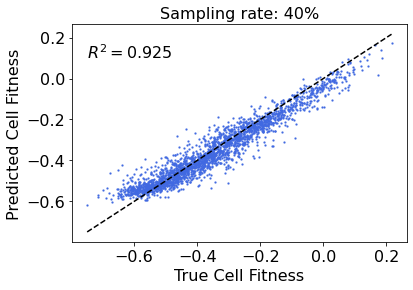

In [127]:
sampling_rate = 40
pred_ = pd.read_csv('raw_y_pred_no_pretrain_update_1_'+str(sampling_rate)+'.csv')
sns.scatterplot(pred_['truth'], pred_['pred'], s = 4, edgecolor='royalblue', color='royalblue')

plot_min = pred_.iloc[:,1:].values.min()
plot_max = pred_.iloc[:,1:].values.max()

plt.plot([plot_min,plot_max],[plot_min,plot_max],color='black', linestyle='--')
plt.ylabel('Predicted Cell Fitness')
plt.xlabel('True Cell Fitness')

r_2 = pearsonr(pred_['truth'], pred_['pred'])[0]**2
plt.text(-0.75, 0.1, r"$R^2=$"+str(round(r_2,3)))

plt.title('Sampling rate: '+str(sampling_rate) +'%', fontsize=16)
plt.savefig('Norman_fitness_'+str(sampling_rate)+'.pdf',dpi=200, bbox_inches = "tight")

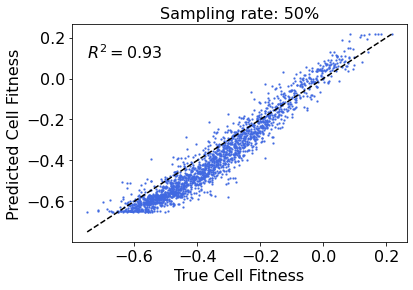

In [128]:
sampling_rate = 50
pred_ = pd.read_csv('raw_y_pred_no_pretrain_update_1_'+str(sampling_rate)+'.csv')
sns.scatterplot(pred_['truth'], pred_['pred'], s = 4,  edgecolor='royalblue', color='royalblue')

plot_min = pred_.iloc[:,1:].values.min()
plot_max = pred_.iloc[:,1:].values.max()

plt.plot([plot_min,plot_max],[plot_min,plot_max],color='black', linestyle='--')
plt.ylabel('Predicted Cell Fitness')
plt.xlabel('True Cell Fitness')

r_2 = pearsonr(pred_['truth'], pred_['pred'])[0]**2
plt.text(-0.75, 0.1, r"$R^2=$"+str(round(r_2,3)))

plt.title('Sampling rate: '+str(sampling_rate) +'%', fontsize=16)
plt.savefig('Norman_fitness_'+str(sampling_rate)+'.pdf',dpi=200, bbox_inches = "tight")

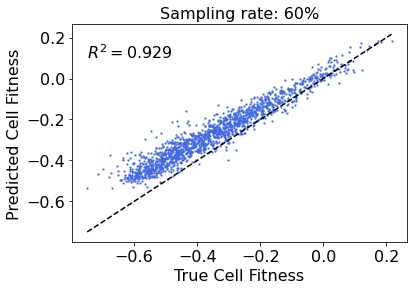

In [129]:
sampling_rate = 60
pred_ = pd.read_csv('raw_y_pred_no_pretrain_update_1_'+str(sampling_rate)+'.csv')
sns.scatterplot(pred_['truth'], pred_['pred'], s = 4, edgecolor='royalblue', color='royalblue')

plot_min = pred_.iloc[:,1:].values.min()
plot_max = pred_.iloc[:,1:].values.max()

plt.plot([plot_min,plot_max],[plot_min,plot_max],color='black', linestyle='--')
plt.ylabel('Predicted Cell Fitness')
plt.xlabel('True Cell Fitness')

r_2 = pearsonr(pred_['truth'], pred_['pred'])[0]**2
plt.text(-0.75, 0.1, r"$R^2=$"+str(round(r_2,3)))

plt.title('Sampling rate: '+str(sampling_rate) +'%', fontsize=16)
plt.savefig('Norman_fitness_'+str(sampling_rate)+'.pdf',dpi=200, bbox_inches = "tight")